In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats
import pandas as pd

In [9]:
df = pd.read_excel("data/data_assignment.xlsx")
df_expenses = df[df["Income/Expense"] == "Expense"].copy()
df_expenses = df_expenses["Amount"].copy()
df_incomes = df[df["Income/Expense"] == "Income"].copy()
df_incomes = df_incomes["Amount"].copy()
df["Date"] = pd.to_datetime(df["Date"]) # makes sure dates are in datetime format
print(df.describe())

                                Date      Amount
count                            280  280.000000
mean   2025-04-17 07:13:15.214285824   17.445714
min              2025-03-01 13:30:00    0.100000
25%              2025-03-24 00:11:45    2.000000
50%              2025-04-14 22:10:30    5.150000
75%              2025-05-09 02:09:30   12.100000
max              2025-06-10 10:11:00  400.000000
std                              NaN   43.862238


In [10]:
def create_ecdf(data):
    M1 = np.mean(data)
    M2 = np.mean(data ** 2)

    mu = M1
    sigma2 = M2 - M1 ** 2

    xs = np.arange(np.min(data), np.max(data), 0.1)

    # ECDF
    ecdf = ECDF(data)
    plt.figure(figsize=(8,6))
    plt.step(ecdf.x, ecdf.y, color='black', where='post', label="Empirical CDF")

    results = []

    # 1. Normal
    fitNormDist = stats.norm(mu, np.sqrt(sigma2))
    plt.plot(xs, fitNormDist.cdf(xs), 'b', label='Normal')
    ks_stat, pval = stats.kstest(data, fitNormDist.cdf)
    results.append(("Normal", ks_stat, pval))

    # 2. Gamma
    alpha = M1 ** 2 / (M2 - M1 ** 2)
    beta = M1 / (M2 - M1 ** 2)
    fitGammaDist = stats.gamma(alpha, scale=1/beta)
    plt.plot(xs, fitGammaDist.cdf(xs), 'r', label='Gamma')
    ks_stat, pval = stats.kstest(data, fitGammaDist.cdf)
    results.append(("Gamma", ks_stat, pval))

    # 3. Exponential
    lam = 1 / M1
    fitExpDist = stats.expon(scale=1/lam)
    plt.plot(xs, fitExpDist.cdf(xs), 'g', label="Exponential")
    ks_stat, pval = stats.kstest(data, fitExpDist.cdf)
    results.append(("Exponential", ks_stat, pval))

    # 4. Uniform
    a, b = np.min(data), np.max(data)
    fitUnifDist = stats.uniform(loc=a, scale=b - a)
    plt.plot(xs, fitUnifDist.cdf(xs), color='orange', label='Uniform')
    ks_stat, pval = stats.kstest(data, fitUnifDist.cdf)
    results.append(("Uniform", ks_stat, pval))

    # 5. Lognormal
    shape, _, scale = stats.lognorm.fit(data)
    fitLogNorm = stats.lognorm(shape, scale=scale)
    plt.plot(xs, fitLogNorm.cdf(xs), 'purple', label='Lognormal')
    ks_stat, pval = stats.kstest(data, fitLogNorm.cdf)
    results.append(("Lognormal", ks_stat, pval))

    # 6. Log-logistic
    c, _, scale = stats.fisk.fit(data)
    fitLogLogis = stats.fisk(c, scale=scale)
    plt.plot(xs, fitLogLogis.cdf(xs), 'brown', label='Log-logistic')
    ks_stat, pval = stats.kstest(data, fitLogLogis.cdf)
    results.append(("Log-logistic", ks_stat, pval))

    # Finalize plot
    plt.legend()
    plt.title("ECDF with Distribution Fits")
    plt.xlabel("x")
    plt.ylabel("CDF")
    plt.show()

    # Show KS test results
    df = pd.DataFrame(results, columns=["Distribution", "KS Statistic", "p-value"])
    df = df.sort_values(by="KS Statistic")
    print(df)

    # Best distribution
    best = df.iloc[0]
    print("\nBest fit: {} (KS Stat = {:.4f}, p = {:.4f})".format(best['Distribution'], best['KS Statistic'], best['p-value']))

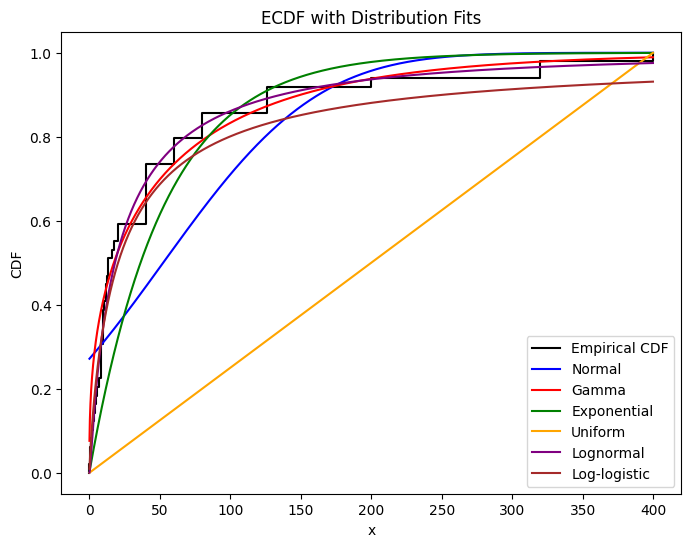

   Distribution  KS Statistic       p-value
5  Log-logistic      0.098010  6.974733e-01
4     Lognormal      0.100063  6.732385e-01
1         Gamma      0.158692  1.519503e-01
2   Exponential      0.281648  6.241987e-04
0        Normal      0.292088  3.376154e-04
3       Uniform      0.657343  2.758316e-21

Best fit: Log-logistic (KS Stat = 0.0980, p = 0.6975)


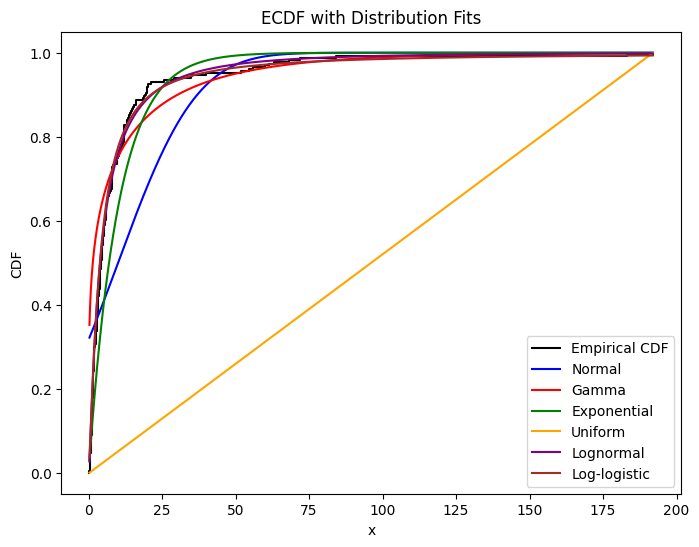

   Distribution  KS Statistic        p-value
5  Log-logistic      0.063652   2.939976e-01
4     Lognormal      0.064503   2.795012e-01
2   Exponential      0.186128   1.769308e-07
0        Normal      0.321731   8.936515e-22
1         Gamma      0.389953   3.797004e-32
3       Uniform      0.822599  1.572378e-172

Best fit: Log-logistic (KS Stat = 0.0637, p = 0.2940)


In [5]:
create_ecdf(df_incomes)
create_ecdf(df_expenses)

In [13]:
# Log-logistic (Fisk) parameters from your partner's ECDF fits
income_fisk_params = {'c': 2.94, 'scale': 4.67}   # example values — replace with actual fitted parameters
expense_fisk_params = {'c': 2.82, 'scale': 6.12}  # example values — replace with actual fitted parameters

In [14]:
from scipy.stats import fisk

def simulate_loglogistic_model(H_days, R, lambda_total, p_income,
                                income_params, expense_params):
    B_end = []
    B_below0 = []
    time_below0 = []

    c_inc, scale_inc = income_params['c'], income_params['scale']
    c_exp, scale_exp = expense_params['c'], expense_params['scale']

    for _ in range(R):
        t = 0
        B = 0
        t_neg = 0
        prev_t = 0

        while t < H_days:
            gap = np.random.exponential(1 / lambda_total)
            t += gap
            if t > H_days: break

            if B < 0:
                t_neg += (t - prev_t)
            prev_t = t

            if np.random.rand() < p_income:
                amount = fisk.rvs(c_inc, scale=scale_inc)
                B += amount
            else:
                amount = fisk.rvs(c_exp, scale=scale_exp)
                B -= amount

        if B < 0:
            t_neg += (H_days - prev_t)

        B_end.append(B)
        B_below0.append(int(B < 0))
        time_below0.append(t_neg)

    # Convert to arrays
    B_end = np.array(B_end)
    B_below0 = np.array(B_below0)
    time_below0 = np.array(time_below0)

    # Confidence Intervals (95%)
    ci_mean = 1.96 * np.std(B_end) / np.sqrt(R)
    prob_neg = np.mean(B_below0)
    ci_prob = 1.96 * np.sqrt(prob_neg * (1 - prob_neg) / R)
    ci_days = 1.96 * np.std(time_below0) / np.sqrt(R)

    return {
        "mean_balance": np.mean(B_end),
        "ci_balance": ci_mean,
        "p_negative": prob_neg,
        "ci_p_negative": ci_prob,
        "mean_days_negative": np.mean(time_below0),
        "ci_days_negative": ci_days
    }


In [15]:
# Replace with actual values from your partner's output
lambda_total = 1.2    # events/day
p_income = 0.42       # 42% of events are income

# Run simulation
result = simulate_loglogistic_model(
    H_days=90,
    R=10000,
    lambda_total=lambda_total,
    p_income=p_income,
    income_params=income_fisk_params,
    expense_params=expense_fisk_params
)

# Print result
for key, value in result.items():
    print(f"{key}: {value:.4f}")


mean_balance: -217.8035
ci_balance: 1.8665
p_negative: 0.9923
ci_p_negative: 0.0017
mean_days_negative: 82.3670
ci_days_negative: 0.2316
